In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  
import seaborn as sns

In [34]:
# Read excel file in variable
df = pd.read_excel(r'C:\Users\tom.rigter\PPAnalytics\EPEXSPOT.xlsx')
df = df.fillna(method='ffill')
df.head()

,Date,Time,EPEX_SPOT_NL
0,2015-01-01,00:00:00,38.50
1,2015-01-01,01:00:00,38.22
2,2015-01-01,02:00:00,35.60
3,2015-01-01,03:00:00,33.00
4,2015-01-01,04:00:00,27.41


In [35]:
# Convert columns so they can be merged and indexed
df['Date'] = df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
df['Time'] = df['Time'].apply(lambda x: x.strftime('%H:%M:%S'))
df.index = pd.to_datetime(df['Date'] + " " + df['Time'], format='%Y-%m-%d %H:%M:%S')

,EPEX_SPOT_NL
count,62496.000000
mean,51.047730
std,42.465181
min,-79.190000
25%,31.440000
50%,40.130000
75%,53.000000
max,620.000000


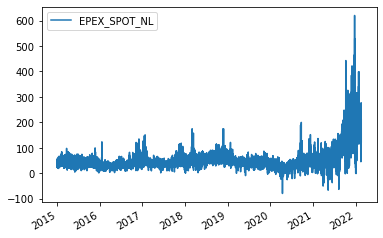

In [36]:
# Plot and properties of dataframe
df.plot(y='EPEX_SPOT_NL', use_index=True)
df.describe()

In [37]:
# Define seasonality columns
df['Hour'] = df.index.hour
df['Weekday'] = df.index.dayofweek
df['Month'] = df.index.month

In [38]:
df.head()

,Date,Time,EPEX_SPOT_NL,Hour,Weekday,Month
2015-01-01 00:00:00,2015-01-01,00:00:00,38.50,0,3,1
2015-01-01 01:00:00,2015-01-01,01:00:00,38.22,1,3,1
2015-01-01 02:00:00,2015-01-01,02:00:00,35.60,2,3,1
2015-01-01 03:00:00,2015-01-01,03:00:00,33.00,3,3,1
2015-01-01 04:00:00,2015-01-01,04:00:00,27.41,4,3,1


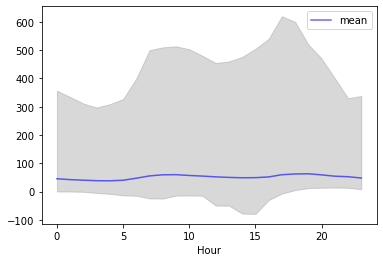

In [39]:
# Plot hourly data
hourly_data = df.groupby('Hour')['EPEX_SPOT_NL'].agg(['min','max','mean'])
hourly_data.reset_index(inplace=True)

ax  = hourly_data.plot(x='Hour', y='mean', c='blue', alpha=0.6)
plt.fill_between(x='Hour',y1='min',y2='max', data=hourly_data, color='grey', alpha=0.3)

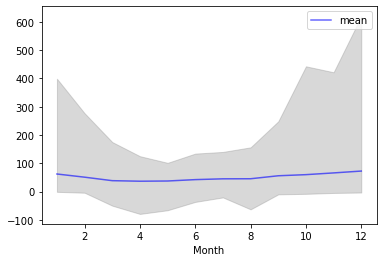

In [40]:
# Plot monthly data
monthly_data = df.groupby('Month')['EPEX_SPOT_NL'].agg(['min','max','mean'])
monthly_data.reset_index(inplace=True)

ax  = monthly_data.plot(x='Month', y='mean', c='blue', alpha=0.6)
plt.fill_between(x='Month',y1='min',y2='max', data=monthly_data, color='grey', alpha=0.3)

<AxesSubplot:ylabel='EPEX_SPOT_NL'>

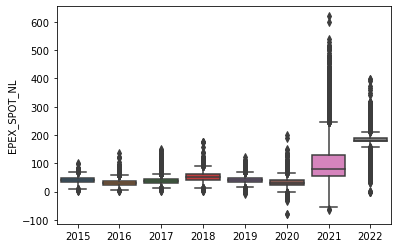

In [41]:
# Plot yearly data
sns.boxplot(x=df.index.year, y='EPEX_SPOT_NL', data=df)

In [42]:
# Function for processing DataFrame to array for LSTM model
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_xy(df, window_size=5):
    df_as_np = df.to_numpy()
    x = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [[a] for a in df_as_np[i:i+window_size]]
        x.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(x), np.array(y) 

In [43]:
# pre-process data for LSTM
WINDOWSIZE = 5
temp = df['EPEX_SPOT_NL']
x, y = df_to_xy(temp, WINDOWSIZE)
x.shape, y.shape

((62491, 5, 1), (62491,))

In [44]:
# split data in train- and testset
x_train, y_train = x[:55000],y[:55000]
x_val, y_val = x[55000:60000],y[55000:60000]
x_test, y_test = x[60000:],y[60000:]

In [45]:
# LSTM model with 4 layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model_1 = Sequential()
model_1.add(InputLayer((5, 1)))
model_1.add(LSTM(64))
model_1.add(Dense(8, activation='relu'))
model_1.add(Dense(1, 'linear'))
model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [46]:
cp = ModelCheckpoint('model_1/', save_best_only=True)
model_1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [47]:
model_1.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
1716/1719 [============================>.] - ETA: 0s - loss: 714.8071 - root_mean_squared_error: 26.7359

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 14s 7ms/step - loss: 713.8818 - root_mean_squared_error: 26.7186 - val_loss: 6515.4658 - val_root_mean_squared_error: 80.7184
Epoch 2/10
1707/1719 [============================>.] - ETA: 0s - loss: 102.4647 - root_mean_squared_error: 10.1225

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 13s 8ms/step - loss: 102.3109 - root_mean_squared_error: 10.1149 - val_loss: 4527.6030 - val_root_mean_squared_error: 67.2875
Epoch 3/10
1718/1719 [============================>.] - ETA: 0s - loss: 48.5308 - root_mean_squared_error: 6.9664

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 16s 9ms/step - loss: 48.5168 - root_mean_squared_error: 6.9654 - val_loss: 3563.8401 - val_root_mean_squared_error: 59.6979
Epoch 4/10
1706/1719 [============================>.] - ETA: 0s - loss: 38.3219 - root_mean_squared_error: 6.1905

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 15s 9ms/step - loss: 38.2737 - root_mean_squared_error: 6.1866 - val_loss: 3021.7346 - val_root_mean_squared_error: 54.9703
Epoch 5/10
1707/1719 [============================>.] - ETA: 0s - loss: 35.1754 - root_mean_squared_error: 5.9309

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 15s 9ms/step - loss: 35.1443 - root_mean_squared_error: 5.9283 - val_loss: 2681.8872 - val_root_mean_squared_error: 51.7869
Epoch 6/10
1713/1719 [============================>.] - ETA: 0s - loss: 33.8363 - root_mean_squared_error: 5.8169

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 15s 9ms/step - loss: 33.8417 - root_mean_squared_error: 5.8174 - val_loss: 2530.3669 - val_root_mean_squared_error: 50.3028
Epoch 7/10
1718/1719 [============================>.] - ETA: 0s - loss: 33.2519 - root_mean_squared_error: 5.7664

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 15s 8ms/step - loss: 33.2463 - root_mean_squared_error: 5.7660 - val_loss: 2400.5178 - val_root_mean_squared_error: 48.9951
Epoch 8/10
1714/1719 [============================>.] - ETA: 0s - loss: 32.9723 - root_mean_squared_error: 5.7421

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 14s 8ms/step - loss: 32.9263 - root_mean_squared_error: 5.7381 - val_loss: 2246.6443 - val_root_mean_squared_error: 47.3988
Epoch 9/10
1715/1719 [============================>.] - ETA: 0s - loss: 32.7046 - root_mean_squared_error: 5.7188

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 16s 10ms/step - loss: 32.6981 - root_mean_squared_error: 5.7182 - val_loss: 2166.1877 - val_root_mean_squared_error: 46.5423
Epoch 10/10
1711/1719 [============================>.] - ETA: 0s - loss: 32.4092 - root_mean_squared_error: 5.6929

INFO:tensorflow:Assets written to: model_1\assets


INFO:tensorflow:Assets written to: model_1\assets


1719/1719 [==============================] - 14s 8ms/step - loss: 32.5084 - root_mean_squared_error: 5.7016 - val_loss: 2067.6235 - val_root_mean_squared_error: 45.4711


In [50]:
from tensorflow.keras.models import load_model

model_1 = load_model('model_1/')

In [51]:
train_predictions = model_1.predict(x_train).flatten()
train_results = pd.DataFrame(data={'train predictions':train_predictions, 'actuals':y_train})
train_results

,train predictions,actuals
0,25.978046,27.41
1,26.836386,27.52
2,28.250864,26.80
3,27.467531,28.48
4,30.100948,27.71
...,...,...
54995,52.650139,59.84
54996,62.294582,65.70
54997,66.854805,69.24
54998,68.471489,68.92


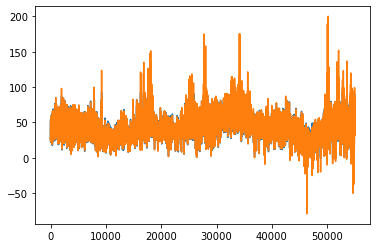

In [52]:
plt.plot(train_results['train predictions'])
plt.plot(train_results['actuals'])
plt.show()

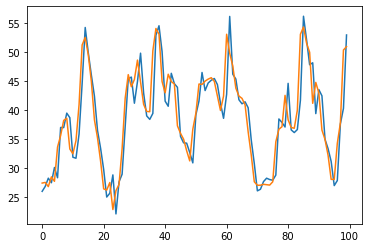

In [54]:
plt.plot(train_results['train predictions'][:100])
plt.plot(train_results['actuals'][:100])
plt.show()

In [55]:
val_predictions = model_1.predict(x_val).flatten()
val_results = pd.DataFrame(data={'validation predictions':val_predictions, 'actuals':y_val})
val_results

,validation predictions,actuals
0,54.958054,49.90
1,46.927479,42.49
2,41.014595,43.16
3,41.592514,43.76
4,43.809097,42.47
...,...,...
4995,94.293327,132.25
4996,94.306183,132.59
4997,94.316292,129.89
4998,94.317825,132.90


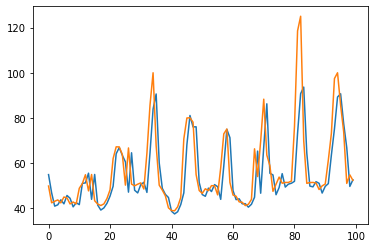

In [57]:
plt.plot(val_results['validation predictions'][:100])
plt.plot(val_results['actuals'][:100])
plt.show()

In [60]:
test_predictions = model_1.predict(x_test).flatten()
test_results = pd.DataFrame(data={'test predictions':test_predictions, 'actuals':y_test})
test_results

,test predictions,actuals
0,94.353554,144.34
1,94.410210,181.11
2,94.451073,199.92
3,94.378609,202.98
4,94.129997,201.26
...,...,...
2486,94.170631,212.76
2487,93.881157,179.90
2488,93.653870,158.03
2489,93.773033,153.90


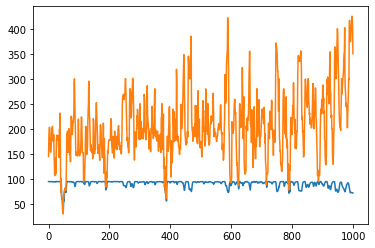

In [62]:
plt.plot(test_results['test predictions'][:1000])
plt.plot(test_results['actuals'][:1000])
plt.show()